In [97]:
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

from rl.agents.dqn import DQNAgent
from rl.policy import EpsGreedyQPolicy, LinearAnnealedPolicy
from rl.memory import SequentialMemory

import os
import dill
%load_ext autoreload


#os.listdir()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [98]:
#dill.load_session('Agent.db')

In [99]:
from Distillation_simple1 import simulator

In [100]:
%autoreload

In [101]:
env = simulator()
nb_actions = env.action_space.n
env.observation_space, env.action_space

(Box(6,), Discrete(5))

In [102]:
# Next, we build a very simple model.
model = Sequential()
model.add(Flatten(input_shape=(1,) + env.observation_space.shape))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(nb_actions, activation = 'linear'))
print(model.summary())


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 6)                 0         
_________________________________________________________________
dense_21 (Dense)             (None, 16)                112       
_________________________________________________________________
dense_22 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_23 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_24 (Dense)             (None, 5)                 85        
Total params: 741
Trainable params: 741
Non-trainable params: 0
_________________________________________________________________
None


In [103]:
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=1., value_min=.1, value_test=.05, nb_steps=10000)
memory = SequentialMemory(limit=50000, window_length=1)
dqn = DQNAgent(model=model, nb_actions=nb_actions, memory=memory, nb_steps_warmup=9,
target_model_update=1e-2, policy=policy, gamma = 0.95)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])

In [104]:
# Okay, now it's time to learn something! We visualize the training here for show, but this slows down training quite a lot. 
hist = dqn.fit(env, nb_steps=20000)

Training for 20000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 44s 4ms/step - reward: -153.4541
2166 episodes - episode_reward: -708.442 [-13060.732, 959.620] - loss: 28190.819 - mean_absolute_error: 520.153 - mean_q: 352.800 - mean_eps: 0.550

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 40s 4ms/step - reward: 119.2519
done, took 83.911 seconds


In [105]:
print(hist.history.keys())

dict_keys(['episode_reward', 'nb_episode_steps', 'nb_steps'])


In [106]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

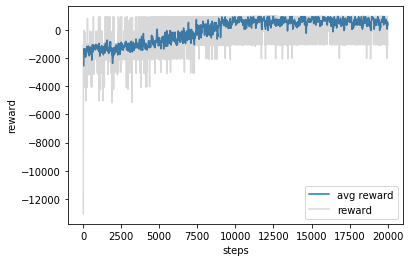

In [107]:
smoothed_rews = running_mean(hist.history['episode_reward'], 10)
plt.plot(hist.history['nb_steps'][-len(smoothed_rews):], smoothed_rews)
plt.plot(hist.history['nb_steps'],hist.history['episode_reward'],color='grey', alpha=0.3)
plt.xlabel("steps")
plt.ylabel("reward")
plt.legend(["avg reward", "reward"])

In [113]:
dqn.test(env, visualize = True)

Testing for 1 episodes ...
total cost: 4.8695902303716 sep_order = [2]
total cost: 12.887026149728296 sep_order = [2, 0]
total cost: 17.048435922079037 sep_order = [2, 0, 4]
total cost: 63.66744361094963 sep_order = [2, 0, 4, 1]
total cost: 107.44676564288713 sep_order = [2, 0, 4, 1, 3]
Episode 1: reward: 936.333, steps: 5


In [114]:
env.sep_order
env.total_cost

107.44676564288713

In [115]:
test_env = simulator()
test_step = env.sep_order
for i in range(5):
    test_env.step(test_step[i])
test_env.total_cost

107.44676564288713

In [116]:
# Checking DQN agent against random selections
counter_env = simulator()
counter_step = [0,1,2,3,4]
counter_env1 = simulator()
counter_step1 = [2, 0, 3, 4, 1]

for i in range(5):
    counter_env.step(counter_step[i])
    counter_env1.step(counter_step1[i])
counter_env.total_cost, counter_env1.total_cost

(126.63416958186147, 106.92504089730132)

In [112]:
#dill.dump_session('Agent.db')